In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from photoz_utils import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
photoz = pd.read_csv('/mnt/data/HSC/HSC_v6/HSC_v6.csv')

In [3]:
photoz = photoz[['object_id','g_cmodel_mag','r_cmodel_mag','i_cmodel_mag','z_cmodel_mag','y_cmodel_mag', 'specz_redshift']]

In [4]:
strata = np.arange(0, 4.5, 0.5) #  total redshift range in half steps

In [5]:
photoz['specz_cat'] = pd.cut(photoz['specz_redshift'], bins=strata, labels=strata[0:-1])
print(len(photoz['specz_redshift']))
print(photoz['specz_cat'].value_counts())

286401
0.0    147583
0.5    103993
1.0     14389
2.0      7799
1.5      6409
2.5      4078
3.0      1629
3.5       521
Name: specz_cat, dtype: int64


In [6]:
strata_sample_dist = np.array([30000, 20000, 2000, 1200, 2000, 1000, 400, 50]) # desired number of samples in each stratum
# this version uses Billy's strata: https://github.com/astrodatalab/photoz/blob/main/code/Stratified%20Ensemble%20BNN.ipynb
strata_counts = np.array(photoz['specz_cat'].value_counts())
strata_counts = np.insert(strata_counts, 0, 0) # total number of samples in each stratum

In [7]:
strata_indexes = [] # iteratively add the previous elements, used to make stratified test and train sets
for i in range(0, len(strata_counts)):
    if i == len(strata_counts) - 1:
        strata_indexes.append(np.sum(strata_counts))
    else:
        strata_indexes.append(np.sum(strata_counts[0: i + 1]))
    

In [8]:
strata_indexes # used to cut photoz_sorted by strata

[0, 147583, 251576, 265965, 273764, 280173, 284251, 285880, 286401]

In [9]:
photoz_arr = photoz.values.tolist()

In [10]:
photoz_sorted = sorted(photoz_arr, key=lambda x : x[6]) # set redshifts in ascending order for ease

In [11]:
# 0 -> object id
# 1-5 -> mags
# 6 -> redshift
# 7 -> stratum

In [12]:
stratified_list = []
stratified_train = []
stratified_test = []

for i in range(0, len(strata) - 1):
    stratified_list.append(list(photoz_sorted[strata_indexes[i]:strata_indexes[i + 1]]))
    # shuffle it
    np.random.shuffle(stratified_list[i])

for i in range (0, len(strata) - 1):
    stratified_train.append(list(stratified_list[i][0:strata_sample_dist[i]]))
    stratified_test.append(list(stratified_list[i][strata_sample_dist[i]:]))

In [13]:
X_train = []
y_train = []
for i in range(len(stratified_train)):
    for j in range(len(stratified_train[i])):
        X_train.append(stratified_train[i][j][1:6]) # mags
        y_train.append(stratified_train[i][j][6]) # redshift labels

In [14]:
X_test = []
y_test = []
for i in range(len(stratified_test)):
    for j in range(len(stratified_test[i])):
        X_test.append(stratified_test[i][j][1:6]) # mags
        y_test.append(stratified_test[i][j][6]) # redshift labels

In [15]:
scaler = StandardScaler()
scaler.fit(X_train) # don't fit X_test !!
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
X_train = pd.DataFrame(data=X_train, columns=['g_cmodel_mag','r_cmodel_mag','i_cmodel_mag','z_cmodel_mag','y_cmodel_mag'])
X_test = pd.DataFrame(data=X_test, columns=['g_cmodel_mag','r_cmodel_mag','i_cmodel_mag','z_cmodel_mag','y_cmodel_mag'])

In [22]:
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [23]:
# rand forest model
rand_forest_model = RandomForestRegressor(n_estimators=200)
rand_forest_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200)

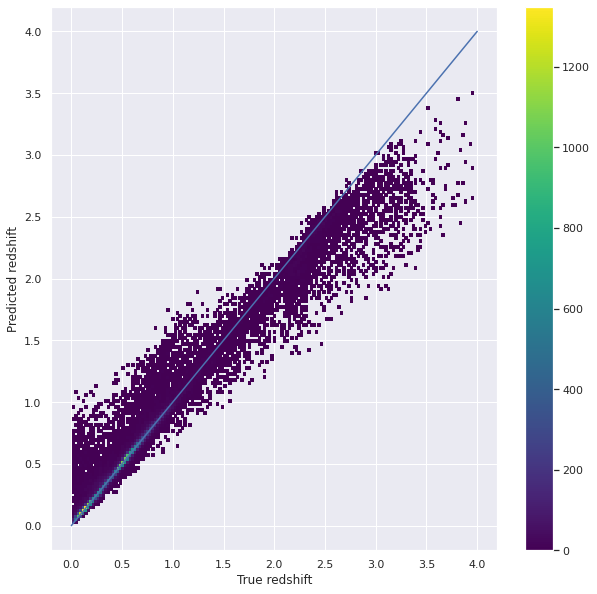

In [24]:
y_train_pred = rand_forest_model.predict(X_train)
y_train_pred = pd.Series(y_train_pred)
plot_predictions(y_train_pred, y_train)

Train MSE: 0.01436762680377127
Average loss: 0.05314351782821017
Bias: 0.0005469668894821885
Scatter: 0.01457826340006196
Outlier Rate: 0.17899382171226833


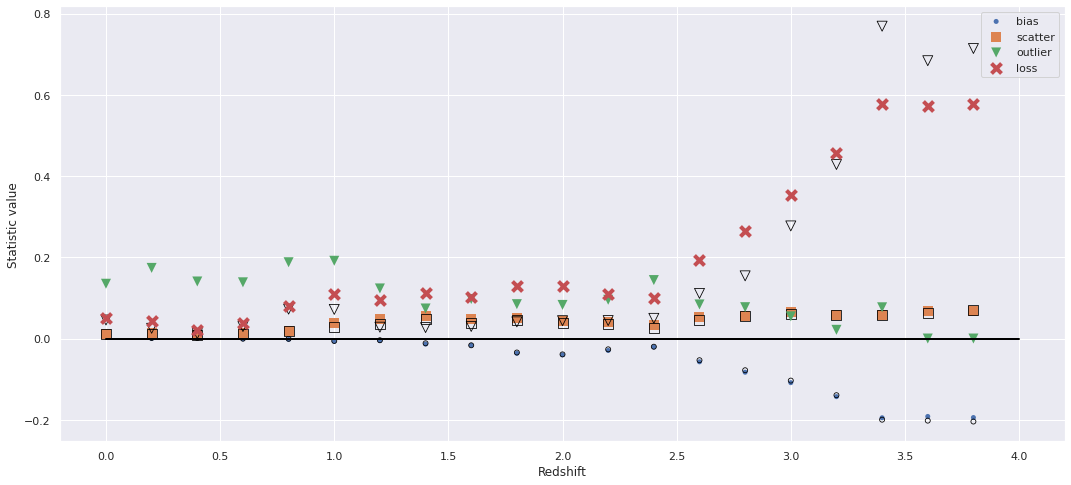

In [25]:
metrics_agg = get_point_metrics(y_train_pred, y_train)
metrics_binned = get_point_metrics(y_train_pred, y_train, binned=True)
plot_point_metrics(metrics_binned)

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
print(f'Train MSE: {train_mse}')
print(f'Average loss: {np.mean(calculate_loss(y_train_pred, y_train))}')
print(f'Bias: {calculate_bias(y_train_pred, y_train)}')
print(f'Scatter: {calculate_scatter(y_train_pred, y_train)}')
print(f'Outlier Rate: {calculate_outlier_rate(y_train_pred, y_train)}')

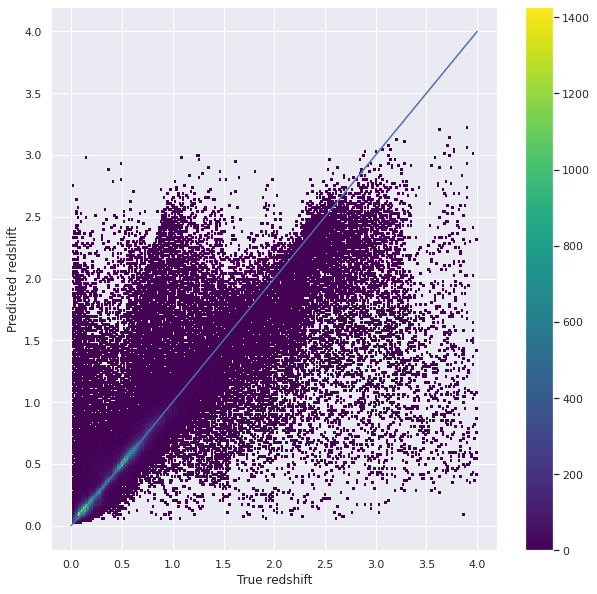

In [26]:
y_test_pred = rand_forest_model.predict(X_test)
y_test_pred = pd.Series(y_test_pred, index=y_test.index)
plot_predictions(y_test_pred, y_test)

Test MSE: 0.10004208139984803
Average loss: 0.13429502428916315
Bias: 0.0015495384333922444
Scatter: 0.0397788768959861
Outlier Rate: 0.17700902281165262


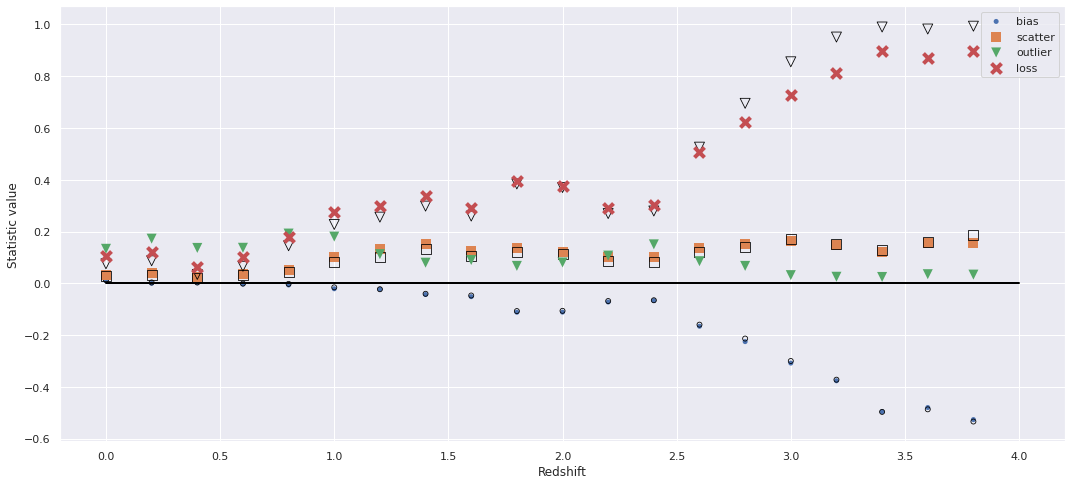

In [27]:
metrics_agg = get_point_metrics(y_test_pred, y_test)
metrics_binned = get_point_metrics(y_test_pred, y_test, binned=True)
plot_point_metrics(metrics_binned)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print(f'Test MSE: {test_mse}')
print(f'Average loss: {np.mean(calculate_loss(y_test_pred, y_test))}')
print(f'Bias: {calculate_bias(y_test_pred, y_test)}')
print(f'Scatter: {calculate_scatter(y_test_pred, y_test)}')
print(f'Outlier Rate: {calculate_outlier_rate(y_test_pred, y_test)}')

In [ ]:
# experiment version: 1